<a href="https://colab.research.google.com/github/Voldemort-vk/WIDS---2025/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PACKAGES


In [136]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

#DATASET


In [137]:
import torch
import torchvision
from torchvision.datasets import MNIST
dataset = MNIST(root = 'data/',download=True)

In [138]:
train_dataset = MNIST(root='data/',train=True)
test_dataset = MNIST(root ='data/',train = False)

In [139]:
train_images = train_dataset.data.numpy().reshape(60000, -1)
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy().reshape(10000, -1)
test_labels = test_dataset.targets.numpy()

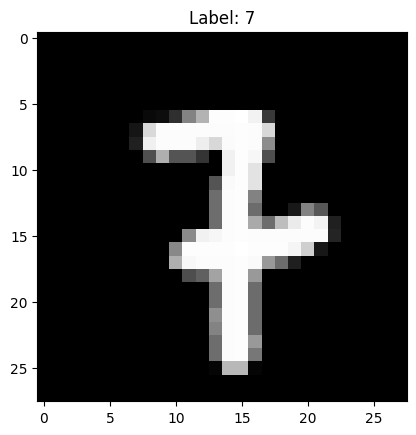

In [140]:
idx = np.random.randint(0, 60000)
plt.imshow(train_images[idx].reshape(28, 28), cmap = 'gray')
plt.title(f'Label: {train_labels[idx]}')
plt.show()

#Normalisation


In [141]:
train_images = (train_images.astype(np.float32)/255.0).T
test_images = (test_images.astype(np.float32)/255.0).T

In [142]:
print(f'Train_images: {train_images.shape}')
print(f'Test_images: {test_images.shape}')

Train_images: (784, 60000)
Test_images: (784, 10000)


In [143]:
def one_hot(Y, num_classes=10):
    Y_flat = Y.flatten()
    m = Y_flat.shape[0]
    one_hot_Y = np.zeros((num_classes, m))
    one_hot_Y[Y_flat, np.arange(m)] = 1
    return one_hot_Y

In [158]:
train_labels_one_hot = one_hot(train_labels)
test_labels_one_hot = one_hot(test_labels)

#Activation Functions

In [145]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def softmax(z):
  z = z - np.max(z, axis=0, keepdims=True)
  return (np.exp(z))/(np.sum(np.exp(z), axis=0, keepdims = True))

def relu(z):
  return np.maximum(0, z)

def tanh(x):
  return np.tanh(x)

def derivative_relu(x):
  return np.array(x>0, dtype = 'float')

def derivative_tanh(x):
  return(1 - np.power(x, 2))

#Parameter Initialisation

In [146]:
def initialise_parameters(layer_dims):
  L = len(layer_dims) - 1
  parameters = {}

  for l in range(1, L+1):
    parameters["w" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
    parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

  return parameters

In [147]:
layer_dims = [28*28, 64, 128, 10]
params = initialise_parameters(layer_dims)

for l in range(1, len(layer_dims)):
  print("shape of W" + str(l) + ":", params['w' + str(l)].shape)
  print("shape of B" + str(l) + ":", params['b' + str(l)].shape)

shape of W1: (64, 784)
shape of B1: (64, 1)
shape of W2: (128, 64)
shape of B2: (128, 1)
shape of W3: (10, 128)
shape of B3: (10, 1)


#Forward Propagation

In [148]:
def forward_propagation(X, parameters, activation = 'relu'):
  forward_cache = {}
  L = len(parameters)//2

  forward_cache["A0"] = X

  for l in range(1, L):
    forward_cache["Z" + str(l)] = parameters["w" + str(l)].dot(forward_cache["A" + str(l-1)]) + parameters["b" + str(l)]
    if activation == 'relu':
      forward_cache["A" + str(l)] = relu(forward_cache["Z" + str(l)])
    else:
      forward_cache["A" + str(l)] = tanh(forward_cache["Z" + str(l)])

  forward_cache["Z" + str(L)] = parameters["w" + str(L)].dot(forward_cache["A" + str(L-1)]) + parameters["b" + str(L)]
  if forward_cache["Z" + str(L)].shape[0] == 1:
    forward_cache["A" + str(L)] = sigmoid(forward_cache["Z" + str(L)])
  else:
    forward_cache["A" + str(L)] = softmax(forward_cache["Z" + str(L)])

  return forward_cache['A' + str(L)], forward_cache

In [149]:
al, forward_cache = forward_propagation(train_images, params, 'relu')

for l in range(len(params)//2 + 1):
  print("shape of A" + str(l) + ":", forward_cache['A' + str(l)].shape)

shape of A0: (784, 60000)
shape of A1: (64, 60000)
shape of A2: (128, 60000)
shape of A3: (10, 60000)


#Cost Function

In [150]:
def compute_cost(AL, Y):
  m = Y.shape[1]

  if Y.shape[0] == 1:
    cost = - (1./m) * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
  else:
    cost = -(1./m) * np.sum(Y*np.log(AL))

  cost = np.squeeze(cost)

  return cost

#Back Propagation

In [151]:

def backward_propagation(AL, Y, parameters, forward_cache, activation):

    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]

    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)

    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['w' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['w' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])

        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [152]:

grads = backward_propagation(forward_cache["A" + str(3)], train_labels, params, forward_cache, 'relu')

for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (10, 60000)
Shape of dW3 : (10, 128)
Shape of dB3 : (10, 1) 

Shape of dZ2 : (128, 60000)
Shape of dW2 : (128, 64)
Shape of dB2 : (128, 1) 

Shape of dZ1 : (64, 60000)
Shape of dW1 : (64, 784)
Shape of dB1 : (64, 1) 



#Update Parameters


In [153]:

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

#Predict

In [154]:

def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)

    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)

    return np.round(np.sum((y_pred == y)/m), 2)

#Model

In [155]:

def model(X, Y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):#lr was 0.009

    np.random.seed(1)
    costs = []

    parameters = initialise_parameters(layers_dims)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters, activation)

        cost = compute_cost(AL, Y)

        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)

        if i % (num_iterations/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{}".format(i, np.round(cost, 2), predict(train_images, train_labels_one_hot, parameters, activation)))

        if i % 10 == 0:
            print("==", end = '')


    return parameters

In [157]:

layers_dims = [28*28, 64, 128, 10]
lr = 0.01
iters = 1000

parameters = model(train_images, train_labels_one_hot, layers_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)


iter:0 	 cost: 2.3 	 train_acc:0.13
iter:100 	 cost: 1.97 	 train_acc:0.58
iter:200 	 cost: 1.49 	 train_acc:0.69
iter:300 	 cost: 1.07 	 train_acc:0.77
iter:400 	 cost: 0.82 	 train_acc:0.81
iter:500 	 cost: 0.68 	 train_acc:0.84
iter:600 	 cost: 0.59 	 train_acc:0.85
iter:700 	 cost: 0.53 	 train_acc:0.86
iter:800 	 cost: 0.49 	 train_acc:0.87
iter:900 	 cost: 0.46 	 train_acc:0.88

#Testing

In [160]:
test_acc = predict(test_images, test_labels_one_hot, parameters, activation='relu')
print("Test accuracy:", test_acc)

Test accuracy: 0.89
